<a href="https://colab.research.google.com/github/mariarodrius/AI-with-Copilot/blob/main/Phishing_Email_Analysis_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'phishing-email-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5074342%2F8502378%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240617%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240617T185523Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7292db61fb07358c45e268a10f5eb9a0a384062660dd2714e87454726ab2903b5838227802f7f62981a42eac671e3afcd9569d088c646f3887f4df65f8b65fa8a0e1991e17902092b904817dc33c1985a2e43ac622801c3a0691ae473d90f2641b2e67cc9a7d7c73f2a46e3095e28e7011f8db214b7e8fba3e330f05538e9d7e7cbaa3d9b0bc67b5927e19e1ff393233b99cdb1f1454e86745d9c30305954c6db4cbdfc0547de7891d0bde59605d3e8acb12b3a91993ce717026b3490edd633c7887d08e4e32cc79116870f46822f2911fa26d2f3ed4dec4eb6cd72e8d359f5d2f56c20170b9d6def3e00631146ee90a5e81a4d4f1778e2003a627526cc2e6ee'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 80864554 bytes downloaded
Downloaded and uncompressed: phishing-email-dataset
Data source import complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('/kaggle/input/phishing-email-dataset/CEAS_08.csv')
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


sender        0
receiver    462
date          0
subject      28
body          0
label         0
urls          0
dtype: int64

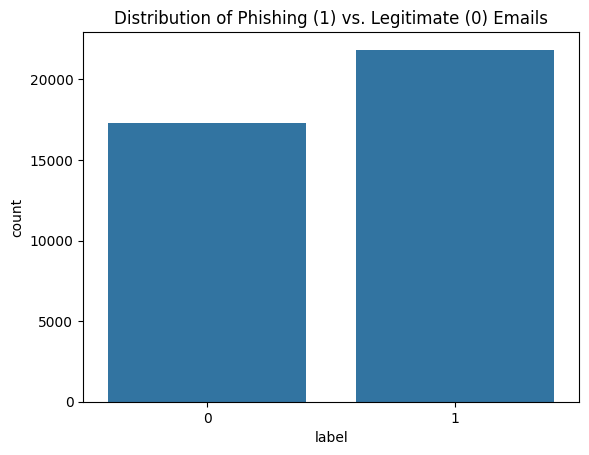

In [4]:
# Distribution of the label column
sns.countplot(x='label', data=df)
plt.title('Distribution of Phishing (1) vs. Legitimate (0) Emails')
plt.show()

In [5]:
# Analyzing the date column
df['date'] = pd.to_datetime(df['date'], format='%a, %d %b %Y %H:%M:%S %z', errors='coerce', utc=True)
print(df['date'].dtype)

datetime64[ns, UTC]


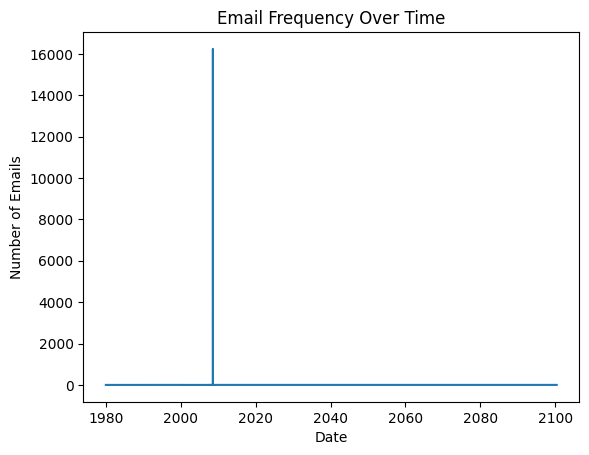

In [6]:
# Creating separate columns for Date and Time
df['Date'] = df['date'].dt.date
df['Time'] = df['date'].dt.time

# Handling any remaining NaT values (if any)
df = df.dropna(subset=['date'])

# Plotting the distribution of emails over time
df['Date'].value_counts().sort_index().plot()
plt.title('Email Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Emails')
plt.show()

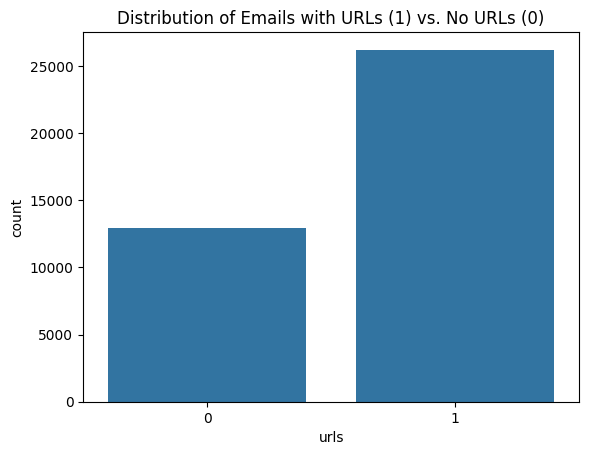

In [7]:
# Distribution of URLs in the emails
sns.countplot(x='urls', data=df)
plt.title('Distribution of Emails with URLs (1) vs. No URLs (0)')
plt.show()

Accuracy: 0.6131545777472213
Confusion Matrix:
[[2638 1701]
 [1675 2713]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.61      0.61      4339
         1.0       0.61      0.62      0.62      4388

    accuracy                           0.61      8727
   macro avg       0.61      0.61      0.61      8727
weighted avg       0.61      0.61      0.61      8727



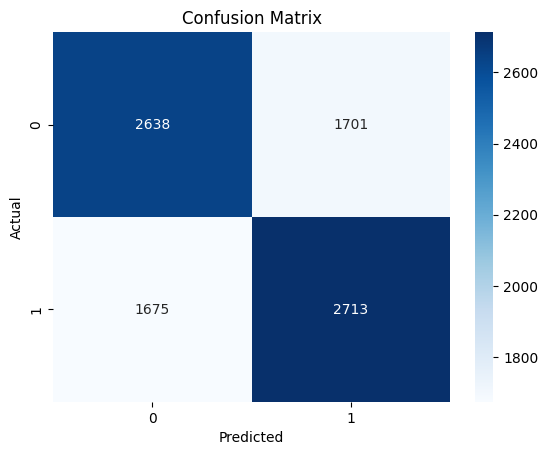

In [8]:
# Preprocessing the body text
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

# Transform the body text to TF-IDF features
X_tfidf = tfidf_vectorizer.fit_transform(df['body'])

# Combining other features with TF-IDF features
features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
features['urls'] = df['urls']
features['label'] = df['label']

# Ensure there are no missing values in the features
features = features.dropna()

# Splitting the dataset into features and target
X = features.drop('label', axis=1)
y = features['label']

# Handle imbalanced data using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Building a Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, zero_division=1)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

# Visualizing the Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [9]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00


In [ ]:
#https://www.geeksforgeeks.org/deploy-a-machine-learning-model-using-streamlit-library/

In [10]:
%%writefile app.py
import streamlit as st
from transformers import pipeline

@st.cache_resource
def load_model():
    return pipeline('text-generation', model='gpt2-xl', device='cuda')

model = load_model()

st.title("Phishing Email Analysis")
prompt = st.text_input("Enter your prompt:", "Once upon a time")

if st.button("Phishing Email Analysis"):
    with st.spinner('Analyzing...'):
        result = model(prompt, max_length=500, num_return_sequences=1)
        st.success(result[0]['generated_text'])

Writing app.py


In [ ]:
!streamlit run app.py --server.port 8511 & npx localtunnel --port 8511




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8511
  Network URL: http://172.28.0.12:8511
  External URL: http://34.82.50.48:8511

npx: installed 22 in 4.165s
your url is: https://nice-worlds-yell.loca.lt
2024-06-17 19:04:26.413945: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 19:04:26.414006: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 19:04:26.562072: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 19:04:26.819675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized 